In [120]:
import os
import sys
import glob

try:
    sys.path.append(glob.glob('../carla/PythonAPI/carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass


import carla

import math
import time
import hydra
import logging
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette("deep")

from numpy import random
from omegaconf import DictConfig, OmegaConf, ValidationError

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.pgm import PGM
from utils.weather import Weather
from core.vehicle_manager import VehicleManager
from core.pedestrian_manager import PedestrianManager
from utils.common import get_actor_blueprints

from hydra.core.config_store import ConfigStore
from schemas.pgm_schema import PGMModel
from schemas.weather_schema import WeatherSchema
from schemas.config_schema import ConfigSchema

In [121]:
def actual_speed(p, value=30):
    return value * (1 - (p / 100))

## Simpler Model

In [116]:
df_list = list()
for rv in [5, 75]:
    try:
        cs = ConfigStore.instance()
        cs.store(group="weather", name="base_weather_model", node=WeatherSchema)
        cs.store(group="model", name="base_pgm_model", node=PGMModel)
        cs.store(name="base_config_model", node=ConfigSchema)
        with hydra.initialize(version_base=None, config_path="../conf"):
            cfg = hydra.compose(
                config_name="config", 
                overrides=[
                    "variables=simpler",
                    "model=simpler",
                    "weather=rain",
                    f"weather.rain={rv}",
                    "weather.hour=9"
                    ])
    except KeyboardInterrupt:
        pass
    finally:
        print('\ndone.')

    pgm = PGM(cfg)
    pgm_variables = pgm.get_variables()
    pgm_states = pgm.get_states()

    # get rain state based on weather
    rain_value = cfg.weather.rain
    rain_state = None
    for s in pgm_states.Rain:
        if (rain_value <= s.value):
            rain_state = s.name
            break

    print(rain_state)

    traffic_state = pgm.predict_state(
        [pgm_variables.Traffic, pgm_variables.Speed], 
        evidence={
            pgm_variables.Rain: rain_state
        }
    )

    traffic_count_list = list()
    speed_list = list()
    data = list()

    rng = random.default_rng()
    for i in range(2400):
        num_of_vehicles = pgm_states.Traffic[traffic_state[pgm_variables.Traffic]].value
        num_of_vehicles = rng.poisson(num_of_vehicles)
        traffic_count_list.append(num_of_vehicles)
        # print(f"Spawning {num_of_vehicles} vehicles.")

        speed = pgm_states.Speed[traffic_state[pgm_variables.Speed]].value
        speed = actual_speed(speed)
        speed = rng.poisson(speed)
        speed_list.append(speed)
        data.append({
            'Rain': rain_state,
            'Traffic': num_of_vehicles,
            'Speed': speed
        })
        # print(f"Maximum speed is {100 - speed}% of the speed limit.")
    df_list.append(pd.DataFrame.from_dict(data))

df = pd.concat(df_list)
df


done.
NO_RAIN


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



done.
RAIN


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Rain  Traffic  Speed
0     NO_RAIN       26     37
1     NO_RAIN       28     59
2     NO_RAIN       30     40
3     NO_RAIN       18     38
4     NO_RAIN       31     40
...       ...      ...    ...
2395     RAIN       12     21
2396     RAIN       11     22
2397     RAIN       14     23
2398     RAIN       10     24
2399     RAIN       12     31

[4800 rows x 3 columns]

In [117]:
pgm.print_cpd('Rain')
pgm.print_cpd('Traffic')
pgm.print_cpd('Speed')

+---------------+-----+
| Rain(NO_RAIN) | 0.2 |
+---------------+-----+
| Rain(RAIN)    | 0.8 |
+---------------+-----+
+----------------+---------------+------------+
| Rain           | Rain(NO_RAIN) | Rain(RAIN) |
+----------------+---------------+------------+
| Traffic(LOW)   | 0.2           | 0.7        |
+----------------+---------------+------------+
| Traffic(HEAVY) | 0.8           | 0.3        |
+----------------+---------------+------------+
+-------------+---------------+------------+
| Rain        | Rain(NO_RAIN) | Rain(RAIN) |
+-------------+---------------+------------+
| Speed(LOW)  | 0.1           | 0.8        |
+-------------+---------------+------------+
| Speed(HIGH) | 0.9           | 0.2        |
+-------------+---------------+------------+


c:\Users\aadim\.conda\envs\carla-pgm\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\aadim\.conda\envs\carla-pgm\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\aadim\.conda\envs\carla-pgm\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


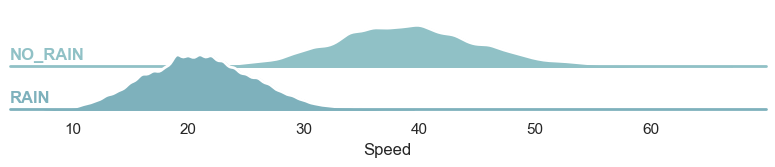

In [119]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# m = df.Time.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Rain", hue="Rain", aspect=15, height=.65, palette=pal)

var = "Speed"

# Draw the densities in a few steps
g.map(sns.kdeplot, var,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, var, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, var)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

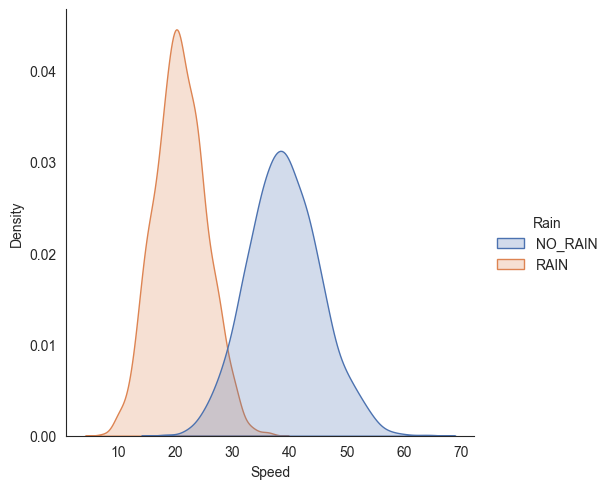

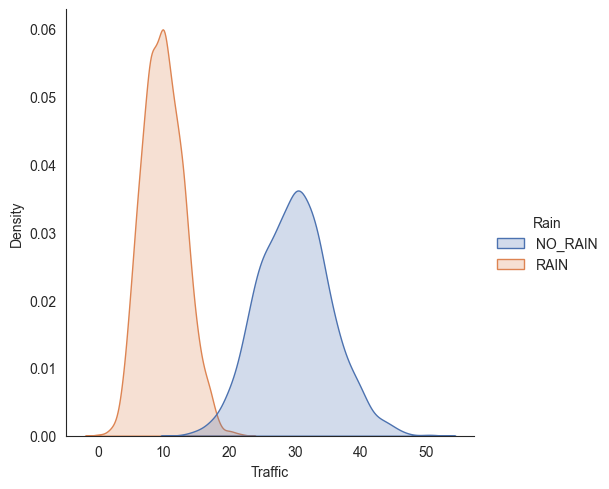

In [5]:
sns.displot(df, x="Speed", hue="Rain", kind='kde', fill=True)
sns.displot(df, x="Traffic", hue="Rain", kind='kde', fill=True)

## Simple Model

In [5]:
df_list = list()
for rv in [0, 50, 75]:
    try:
        cs = ConfigStore.instance()
        cs.store(group="weather", name="base_weather_model", node=WeatherSchema)
        cs.store(group="model", name="base_pgm_model", node=PGMModel)
        cs.store(name="base_config_model", node=ConfigSchema)
        with hydra.initialize(version_base=None, config_path="../conf"):
            cfg = hydra.compose(
                config_name="config", 
                overrides=[
                    "variables=simple",
                    "model=simple",
                    "weather=rain",
                    f"weather.rain={rv}",
                    "weather.hour=9"
                    ])
    except KeyboardInterrupt:
        pass
    finally:
        print('\ndone.')

    pgm = PGM(cfg)
    pgm_variables = pgm.get_variables()
    pgm_states = pgm.get_states()

    # get rain state based on weather
    rain_value = cfg.weather.rain
    rain_state = None
    for s in pgm_states.Rain:
        if (rain_value <= s.value):
            rain_state = s.name
            break

    print(rain_state)

    traffic_state = pgm.predict_state(
        [pgm_variables.Traffic, pgm_variables.Speed], 
        evidence={
            pgm_variables.Rain: rain_state
        }
    )

    traffic_count_list = list()
    speed_list = list()
    data = list()

    rng = random.default_rng()
    for i in range(2400):
        num_of_vehicles = pgm_states.Traffic[traffic_state[pgm_variables.Traffic]].value
        num_of_vehicles = rng.poisson(num_of_vehicles)
        traffic_count_list.append(num_of_vehicles)
        # print(f"Spawning {num_of_vehicles} vehicles.")

        speed = pgm_states.Speed[traffic_state[pgm_variables.Speed]].value
        speed = actual_speed(speed)
        speed = rng.poisson(speed)
        speed_list.append(speed)
        data.append({
            'Rain': rain_state,
            'Traffic': num_of_vehicles,
            'Speed': speed
        })
        # print(f"Maximum speed is {100 - speed}% of the speed limit.")
    df_list.append(pd.DataFrame.from_dict(data))

df = pd.concat(df_list)
df


done.
NO_RAIN


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



done.
LIGHT_RAIN


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]



done.
HEAVY_RAIN


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Rain  Traffic  Speed
0        NO_RAIN       43     30
1        NO_RAIN       29     33
2        NO_RAIN       34     37
3        NO_RAIN       28     26
4        NO_RAIN       27     38
...          ...      ...    ...
2395  HEAVY_RAIN        7     28
2396  HEAVY_RAIN        8     19
2397  HEAVY_RAIN        4     17
2398  HEAVY_RAIN       11     31
2399  HEAVY_RAIN        4     14

[7200 rows x 3 columns]

In [7]:
print("CPD of Rain")
pgm.print_cpd('Rain')
print("\nCPD of Traffic")
pgm.print_cpd('Traffic')
print("\nCPD of Speed")
pgm.print_cpd('Speed')

CPD of Rain
+------------------+-----+
| Rain(NO_RAIN)    | 0.2 |
+------------------+-----+
| Rain(LIGHT_RAIN) | 0.5 |
+------------------+-----+
| Rain(HEAVY_RAIN) | 0.3 |
+------------------+-----+

CPD of Traffic
+----------------+---------------+------------------+------------------+
| Rain           | Rain(NO_RAIN) | Rain(LIGHT_RAIN) | Rain(HEAVY_RAIN) |
+----------------+---------------+------------------+------------------+
| Traffic(LOW)   | 0.1           | 0.4              | 0.9              |
+----------------+---------------+------------------+------------------+
| Traffic(HEAVY) | 0.9           | 0.6              | 0.1              |
+----------------+---------------+------------------+------------------+

CPD of Speed
+-------------+---------------+------------------+------------------+
| Rain        | Rain(NO_RAIN) | Rain(LIGHT_RAIN) | Rain(HEAVY_RAIN) |
+-------------+---------------+------------------+------------------+
| Speed(LOW)  | 0.1           | 0.6             

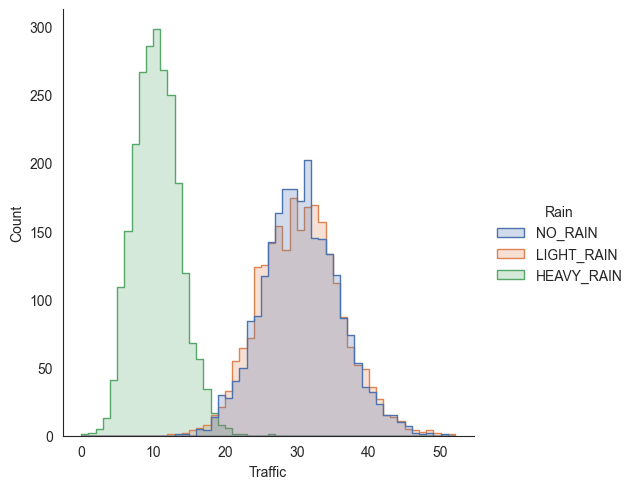

In [7]:
sns.displot(df, x="Traffic", binwidth=1, hue="Rain", element="step")

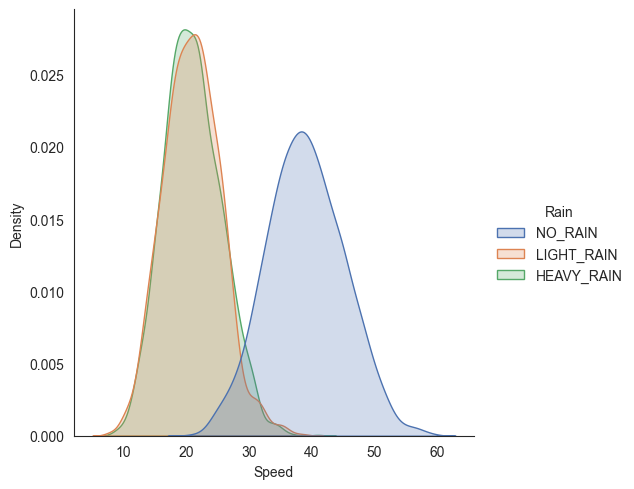

In [8]:
sns.displot(df, x="Speed", hue="Rain", kind='kde', fill=True)

## Learned Model

In [122]:
def time_of_day(hour):
    if hour >= 2 and hour <= 6:
        return 'EARLY_MORNING'
    elif hour > 6 and hour <= 9:
        return 'MORNING'
    elif hour > 9 and hour <= 12:
        return 'LATE_MORNING'
    elif hour > 12 and hour <= 17:
        return 'AFTERNOON'
    elif hour > 17 and hour <= 19:
        return 'EARLY_EVENING'
    elif hour > 19 and hour <= 21:
        return 'EVENING'
    elif hour > 21 and hour <= 23:
        return 'LATE_EVENING'
    else:
        return 'NIGHT'

def get_state_from_config(value, states):
     for s in states:
        if (value <= s.value):
            return s.name

In [ ]:
df_list = list()
for t in [0, 4, 7, 11, 15, 18, 20, 22]:
    for rv in [0, 45, 70, 85]:
        for fv in [0, 45, 70, 85]:
            for cv in [0, 45, 70, 85]:
                try:
                    cs = ConfigStore.instance()
                    cs.store(group="weather", name="base_weather_model", node=WeatherSchema)
                    cs.store(group="model", name="base_pgm_model", node=PGMModel)
                    cs.store(name="base_config_model", node=ConfigSchema)
                    with hydra.initialize(version_base=None, config_path="../conf"):
                        cfg = hydra.compose(
                            config_name="config", 
                            overrides=[
                                "weather=clear",
                                f"weather.hour={t}",
                                f"weather.rain={rv}",
                                f"weather.fog={fv}",
                                f"weather.cloudiness={cv}",
                                "variables=trained"
                                ])
                except KeyboardInterrupt:
                    pass
                finally:
                    print('\nDone.')

                pgm = PGM(cfg, file_path="eCARLA_PGM.xml")
                pgm_variables = pgm.get_variables()
                pgm_states = pgm.get_states()

                # get weather and time state from configuration files
                rain_state = get_state_from_config(cfg.weather.rain, pgm_states.Rain)
                # print(f"Rain state: {rain_state}")

                fog_state = get_state_from_config(cfg.weather.fog, pgm_states.Fog)
                # print(f"Fog state: {fog_state}")

                clouds_state = get_state_from_config(cfg.weather.cloudiness, pgm_states.Clouds)
                # print(f"Cloud state: {clouds_state}")

                time_state = time_of_day(cfg.weather.hour)
                # print(f"Time of day: {time_state}")

                pedestrians_state = pgm.predict_state(
                    [pgm_variables.Pedestrians], 
                    evidence={
                        pgm_variables.Rain: rain_state,
                        pgm_variables.Time: time_state
                    }
                )[pgm_variables.Pedestrians]
                # print(f"No. of Pedestrians: {pedestrians_state}")

                traffic_state = pgm.predict_state(
                    [pgm_variables.Traffic], 
                    evidence={
                        pgm_variables.Fog: fog_state,
                        pgm_variables.Pedestrians: pedestrians_state,
                        pgm_variables.Time: time_state
                    }
                )[pgm_variables.Traffic]
                # print(f"No. of Vehicles: {traffic_state}")

                speed_state = pgm.predict_state(
                    [pgm_variables.Speed], 
                    evidence={
                        pgm_variables.Fog: fog_state,
                        pgm_variables.Pedestrians: pedestrians_state,
                        pgm_variables.Time: time_state,
                        pgm_variables.Traffic: traffic_state
                    }
                )[pgm_variables.Speed]
                # print(f"Speed of Vehicles: {speed_state}")

                data = list()

                rng = random.default_rng()
                for i in range(100):
                    num_of_vehicles = pgm_states.Traffic[traffic_state].value
                    num_of_vehicles = rng.poisson(num_of_vehicles)
                    # print(f"Spawning {num_of_vehicles} vehicles.")

                    speed = pgm_states.Speed[speed_state].value
                    speed = actual_speed(speed)
                    speed = rng.poisson(speed)
                    # print(f"Maximum speed is {100 - speed}% of the speed limit.")

                    num_of_pedestrians = pgm_states.Pedestrians[pedestrians_state].value
                    num_of_pedestrians = rng.poisson(num_of_pedestrians)
                    # print(f"Spawning {num_of_pedestrians} pedestrians.")
                    data.append({
                        'Rain': rain_state,
                        'Time': time_state,
                        'Fog': fog_state,
                        'Clouds': clouds_state,
                        'Traffic': num_of_vehicles,
                        'Speed': speed,
                        'Pedestrians': num_of_pedestrians,
                    })
                    # print(f"Maximum speed is {100 - speed}% of the speed limit.")
                df_list.append(pd.DataFrame.from_dict(data))

df = pd.concat(df_list)

In [188]:
df

Rain          Time     Fog     Clouds  Traffic  Speed  Pedestrians
0   NO_RAIN         NIGHT  NO_FOG  NO_CLOUDS       27     28            3
1   NO_RAIN         NIGHT  NO_FOG  NO_CLOUDS       22     34            7
2   NO_RAIN         NIGHT  NO_FOG  NO_CLOUDS       21     33            4
3   NO_RAIN         NIGHT  NO_FOG  NO_CLOUDS       13     24            4
4   NO_RAIN         NIGHT  NO_FOG  NO_CLOUDS       20     36            6
..      ...           ...     ...        ...      ...    ...          ...
95    HEAVY  LATE_EVENING   HEAVY      HEAVY       31     31           23
96    HEAVY  LATE_EVENING   HEAVY      HEAVY       30     41           23
97    HEAVY  LATE_EVENING   HEAVY      HEAVY       34     42           24
98    HEAVY  LATE_EVENING   HEAVY      HEAVY       30     39           20
99    HEAVY  LATE_EVENING   HEAVY      HEAVY       37     48           19

[51200 rows x 7 columns]

<AxesSubplot:xlabel='Rain', ylabel='Speed'>

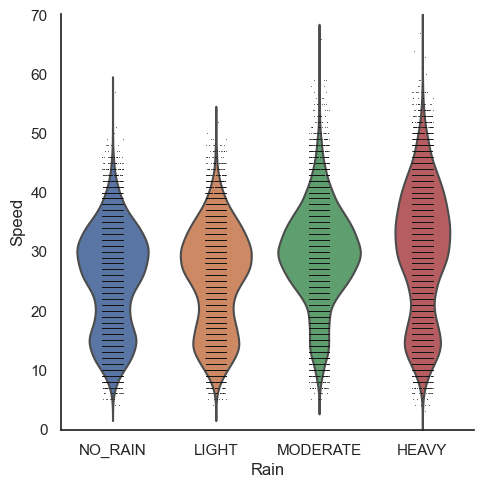

In [189]:
g = sns.catplot(data=df, x="Rain", y="Speed", kind="violin", inner=None)
sns.stripplot(data=df, x="Rain", y="Speed", color="k", size=0.5, ax=g.ax)

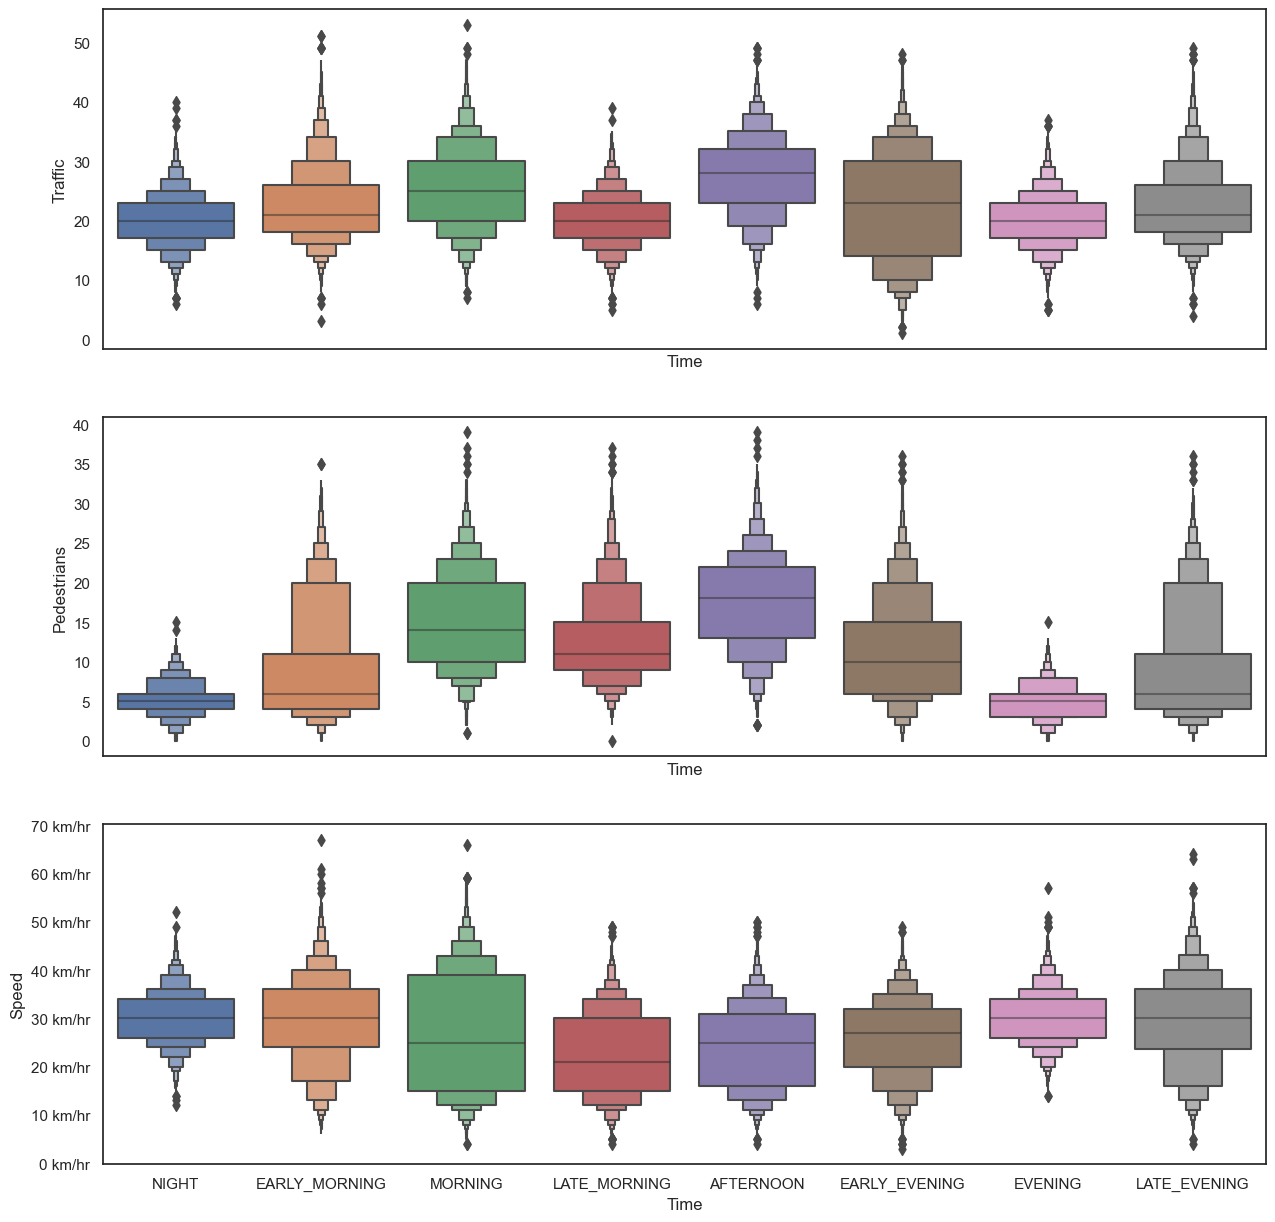

In [233]:
import matplotlib.ticker as mticker
def update_ticks(x, pos):
    return str(int(x)) + ' km/hr'

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
# fig.suptitle('Initial Pokemon - 1st Generation')

sns.boxenplot(
    data=df, x="Time", y="Traffic",
     ax=axes[0]
)

sns.boxenplot(
    data=df, x="Time", y="Pedestrians",
      ax=axes[1]
)

g = sns.boxenplot(
    data=df, x="Time", y="Speed",
     ax=axes[2]
)

g.axes.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
    # ax.yaxis.set_major_formatter('{x:.0f} km/hr')

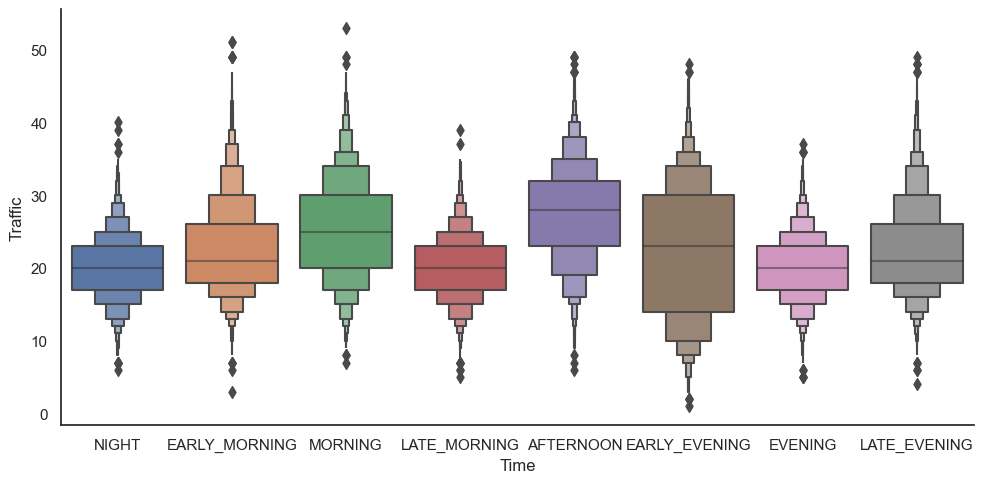

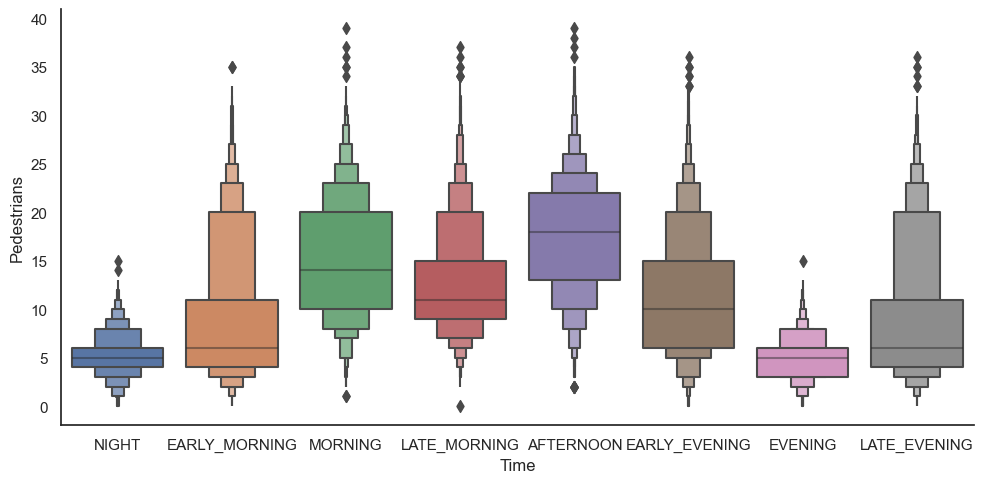

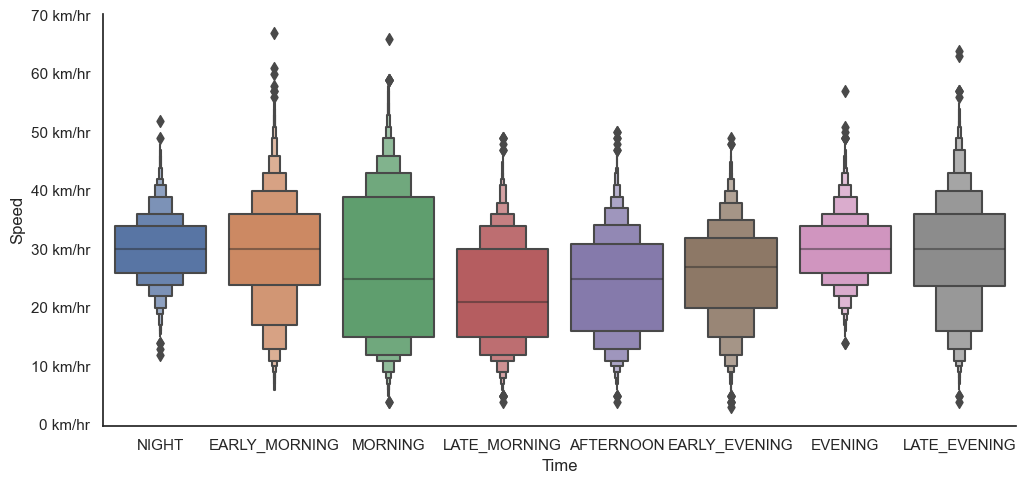

In [224]:
sns.catplot(
    data=df, x="Time", y="Traffic",
    kind="boxen", aspect=2
)

sns.catplot(
    data=df, x="Time", y="Pedestrians",
    kind="boxen", aspect=2
)

g = sns.catplot(
    data=df, x="Time", y="Speed",
    kind="boxen", aspect=2
)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter('{x:.0f} km/hr')

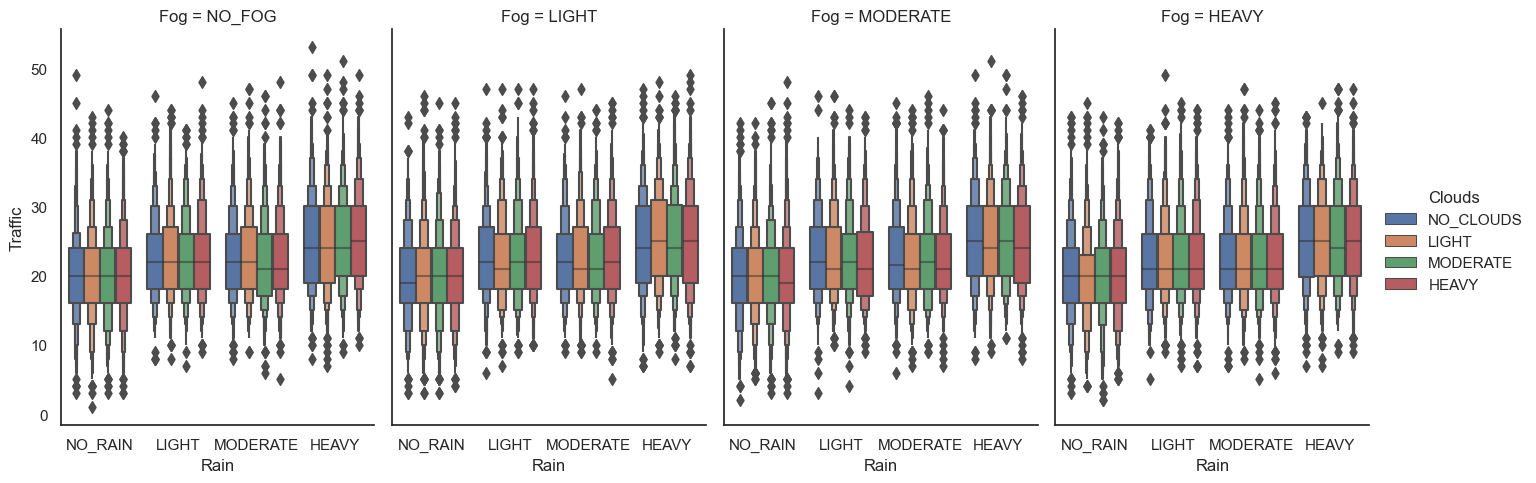

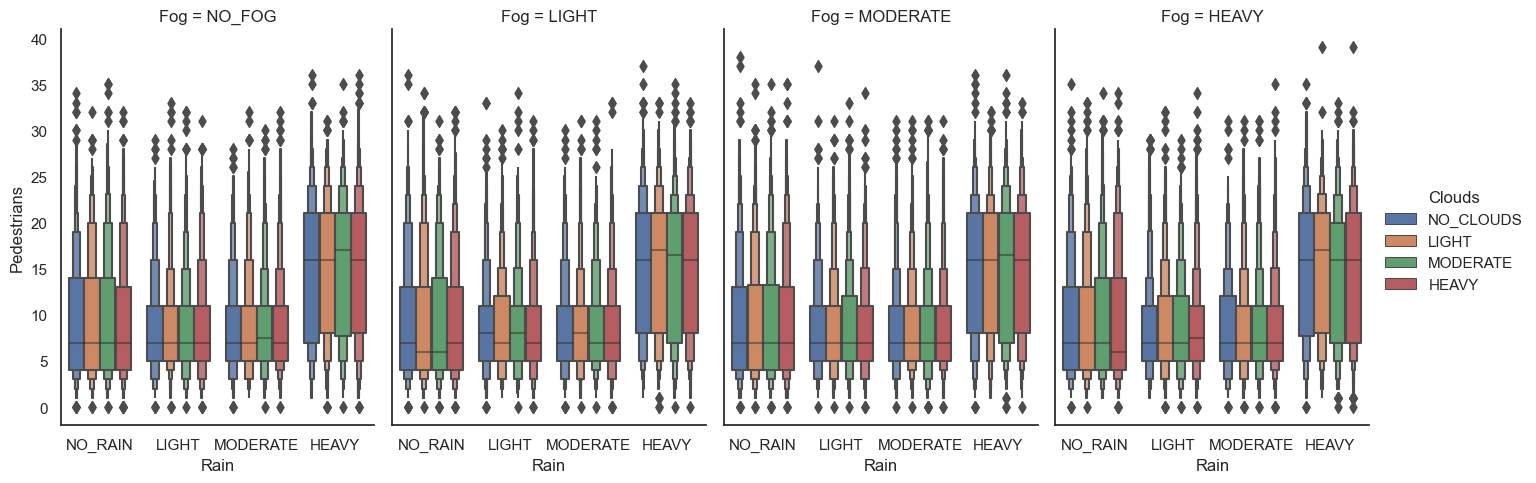

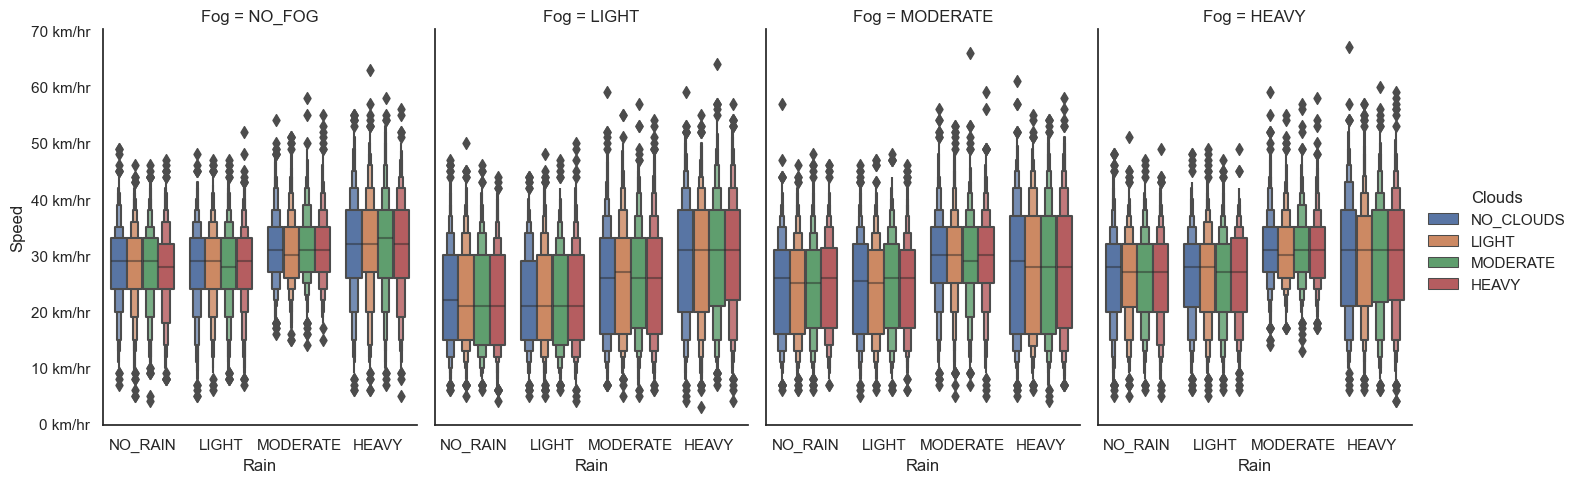

In [191]:
sns.catplot(
    data=df, x="Rain", y="Traffic", hue="Clouds",
    kind="boxen", col="Fog", aspect=0.7 
)

sns.catplot(
    data=df, x="Rain", y="Pedestrians", hue="Clouds",
    kind="boxen", col="Fog", aspect=0.7 
)

g = sns.catplot(
    data=df, x="Rain", y="Speed", hue="Clouds",
    kind="boxen", col="Fog", aspect=0.7 
)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter('{x:.0f} km/hr')

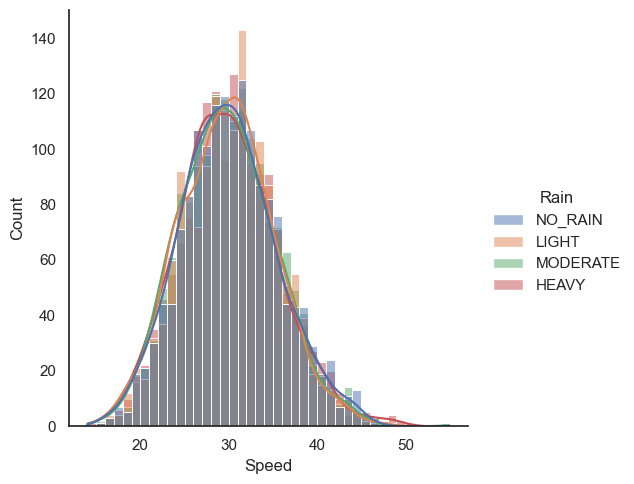

In [135]:

sns.displot(df, x="Speed", binwidth=1, hue="Rain", kde=True)

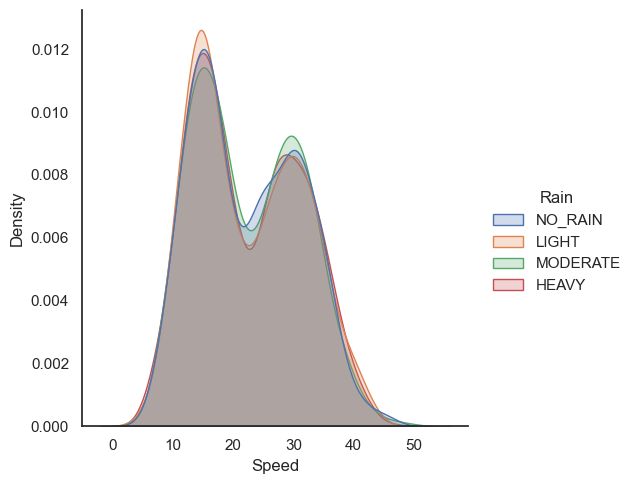

In [126]:
sns.displot(df, x="Speed", hue="Rain", kind='kde', fill=True)

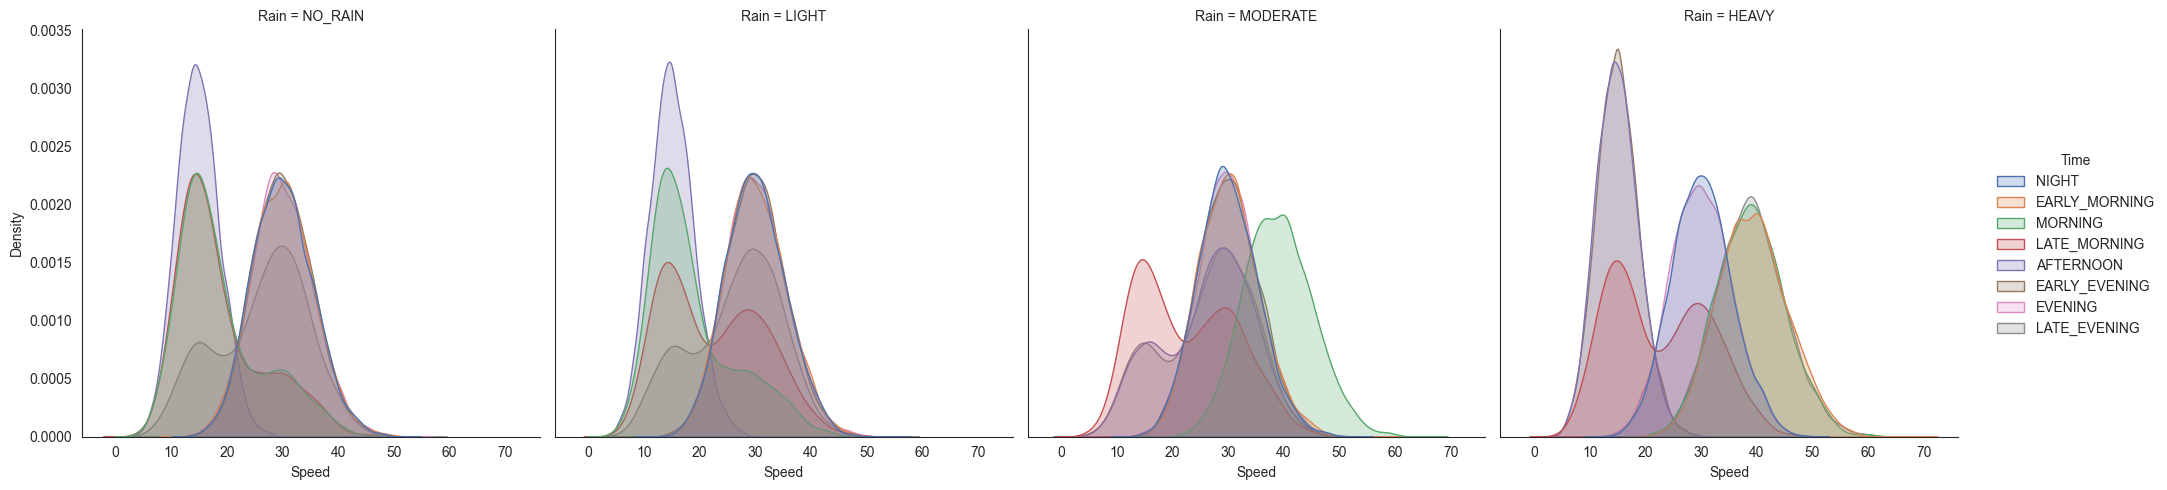

In [34]:

sns.displot(df, x="Speed", hue="Time", col='Rain', kind='kde', fill=True)

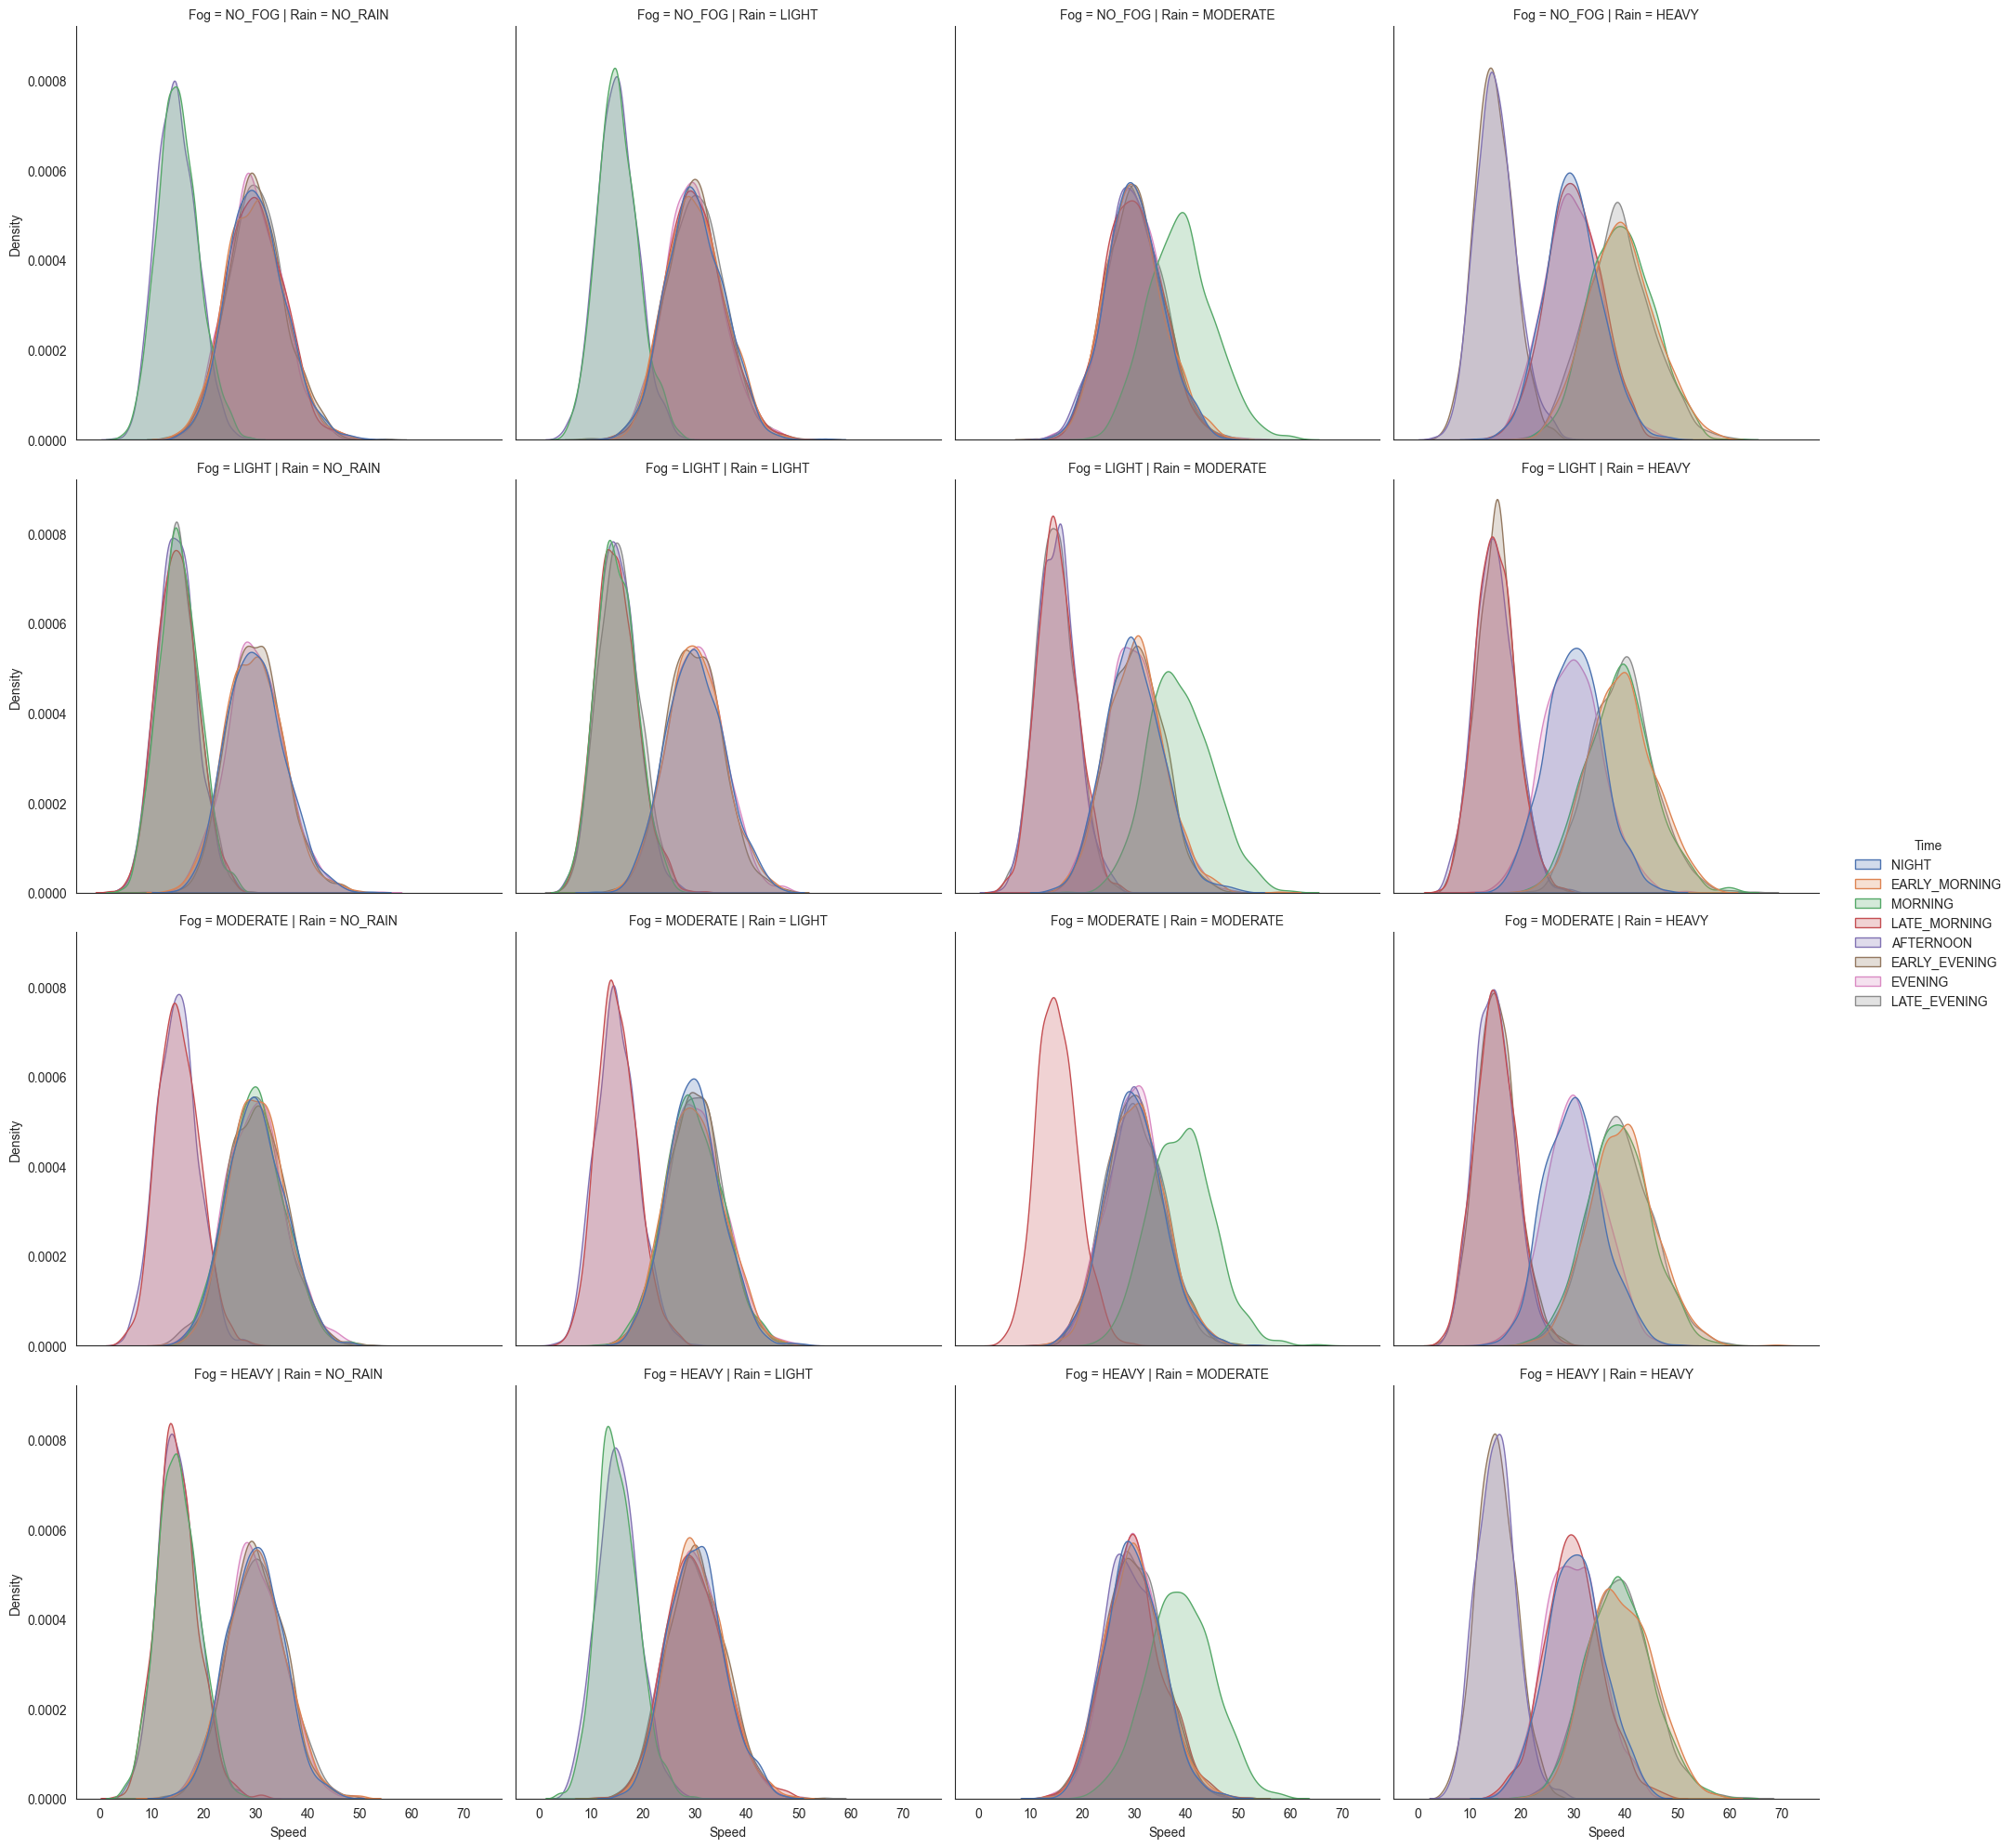

In [36]:

sns.displot(df, x="Speed", hue="Time", col='Rain', row='Fog', kind='kde', fill=True)

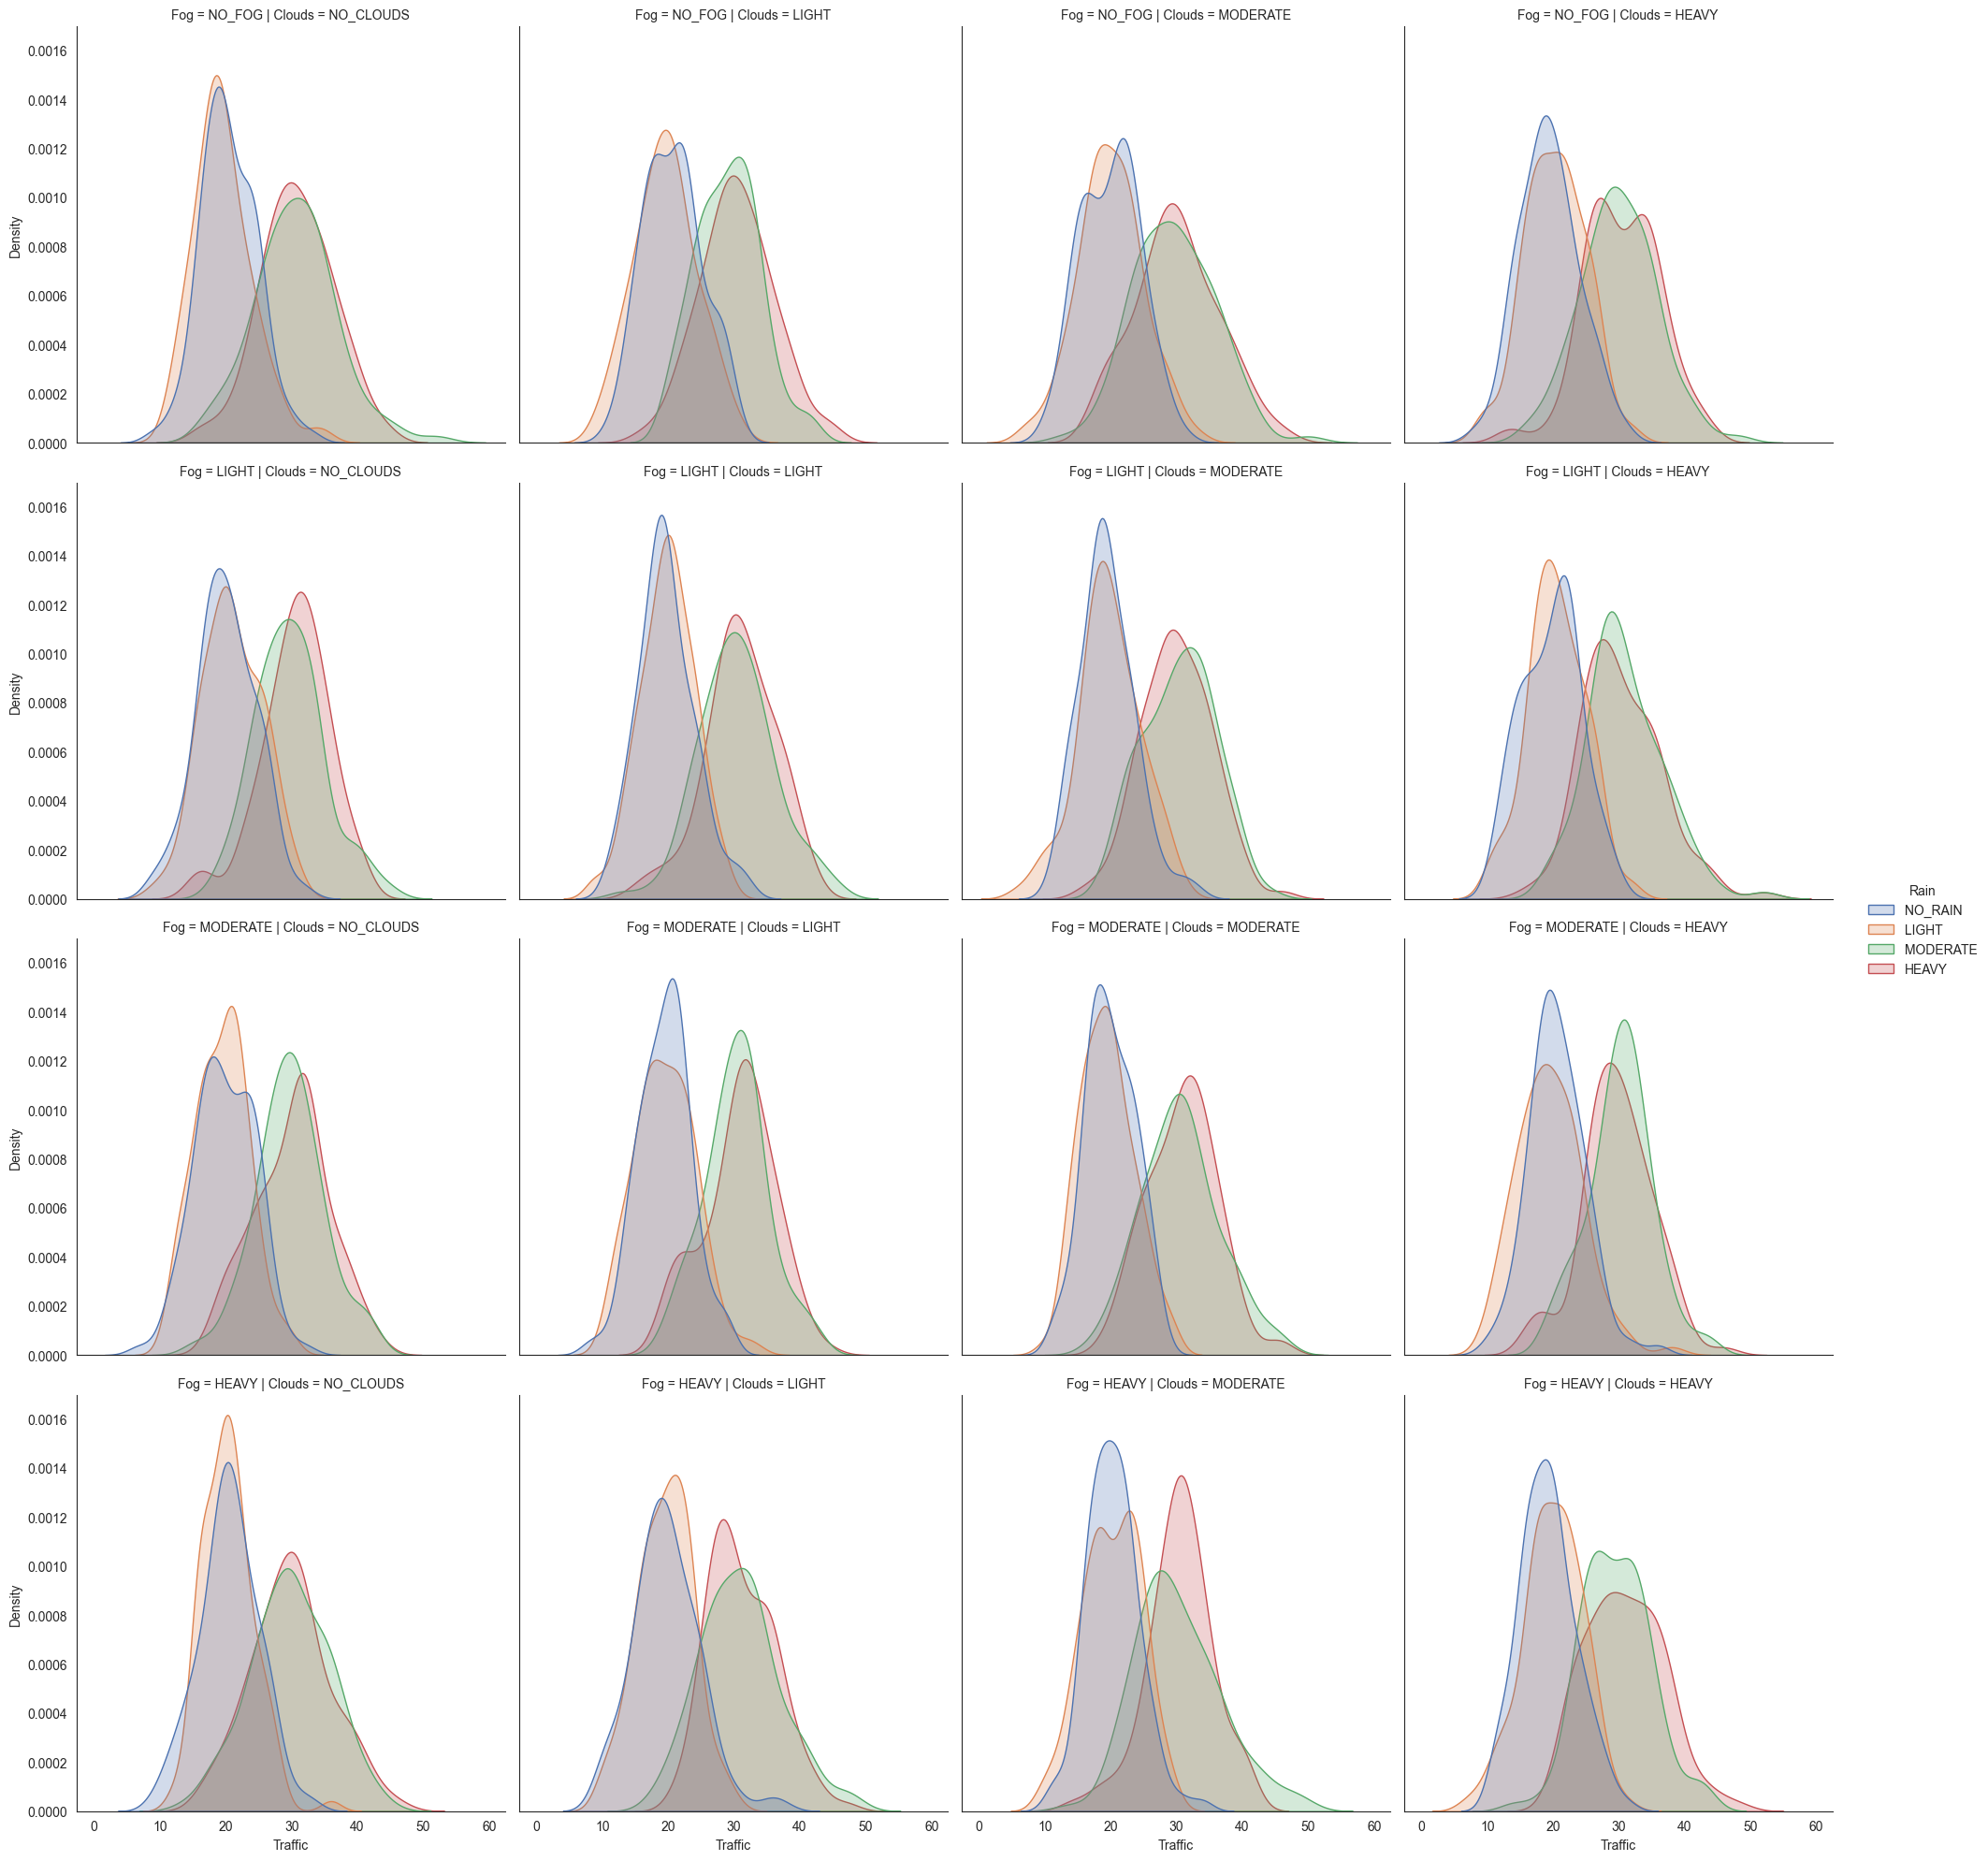

In [16]:

sns.displot(df, x="Traffic", hue="Rain", col='Clouds', row='Fog', kind='kde', fill=True)

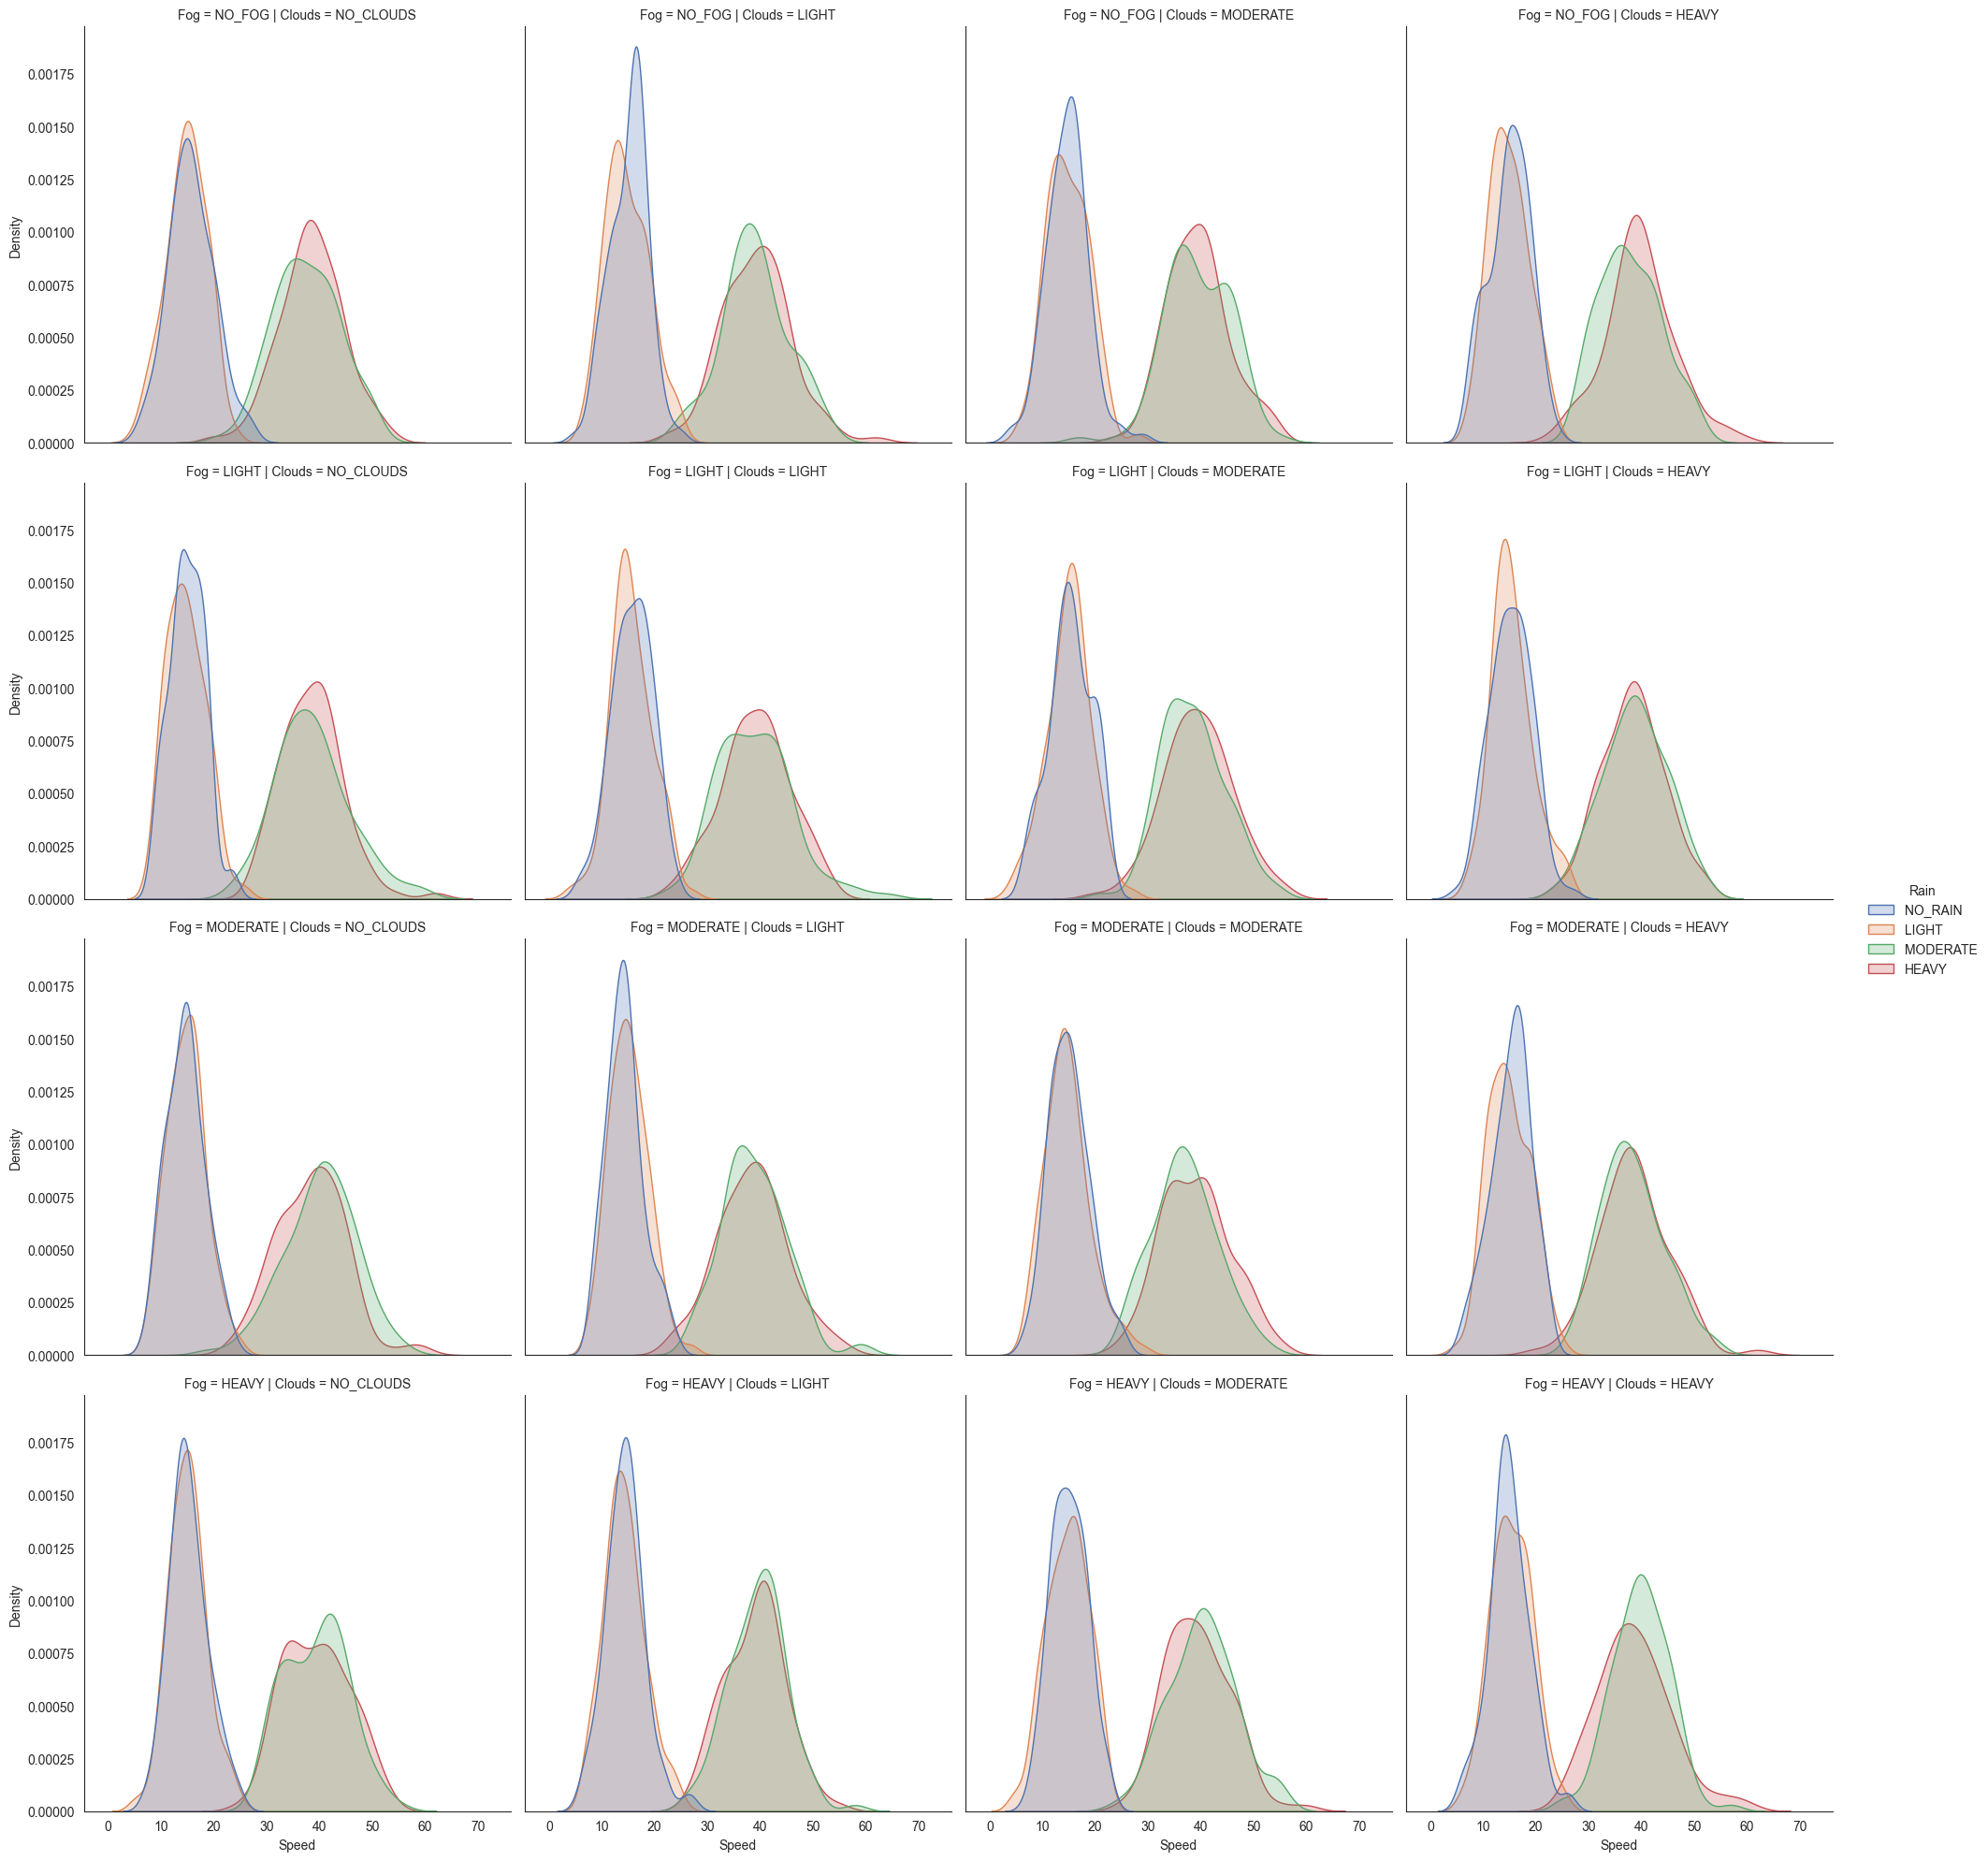

In [15]:

sns.displot(df, x="Speed", hue="Rain", col='Clouds', row='Fog', kind='kde', fill=True)

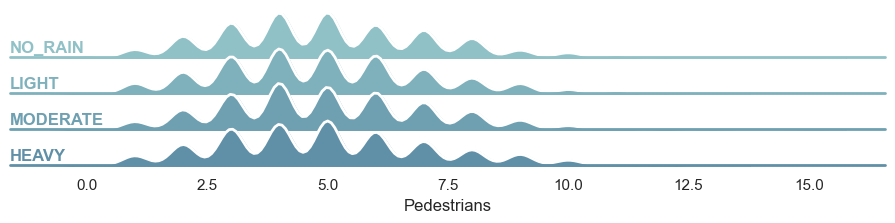

In [138]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# m = df.Time.map(ord)
# df["x"] += m

var = "Pedestrians"
metric = "Rain"

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row=metric, hue=metric, aspect=15, height=.65, palette=pal)



# Draw the densities in a few steps
g.map(sns.kdeplot, var,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, var, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, var)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

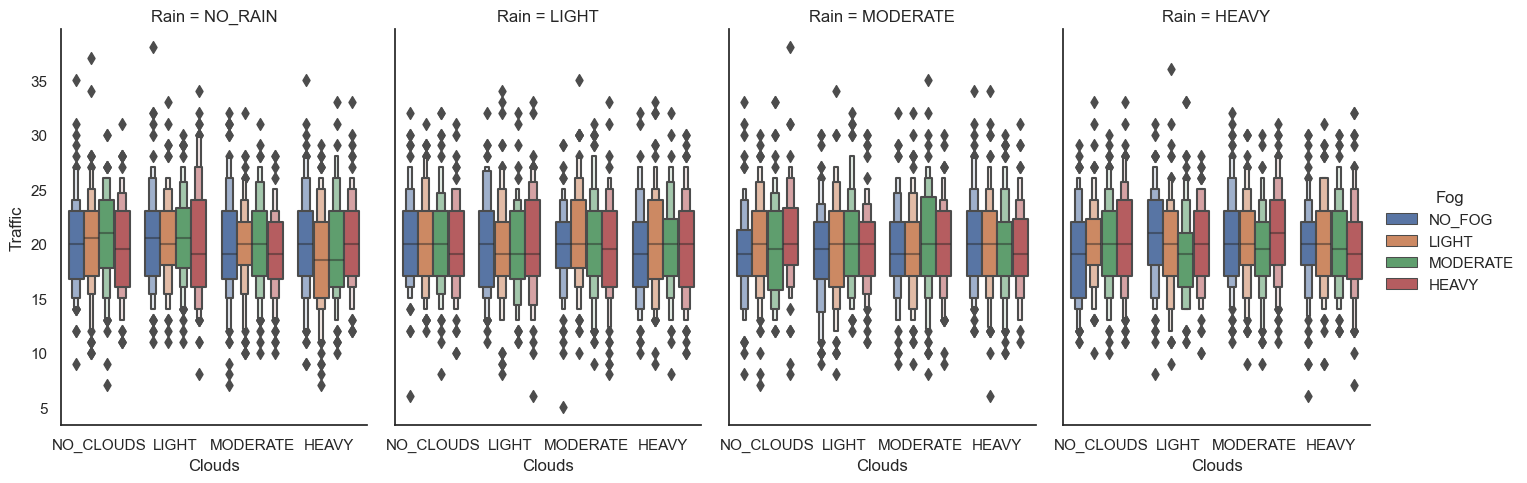

In [139]:
sns.catplot(
    data=df, x="Clouds", y="Traffic", hue="Fog",
    kind="boxen", col="Rain", aspect=.7, 
)

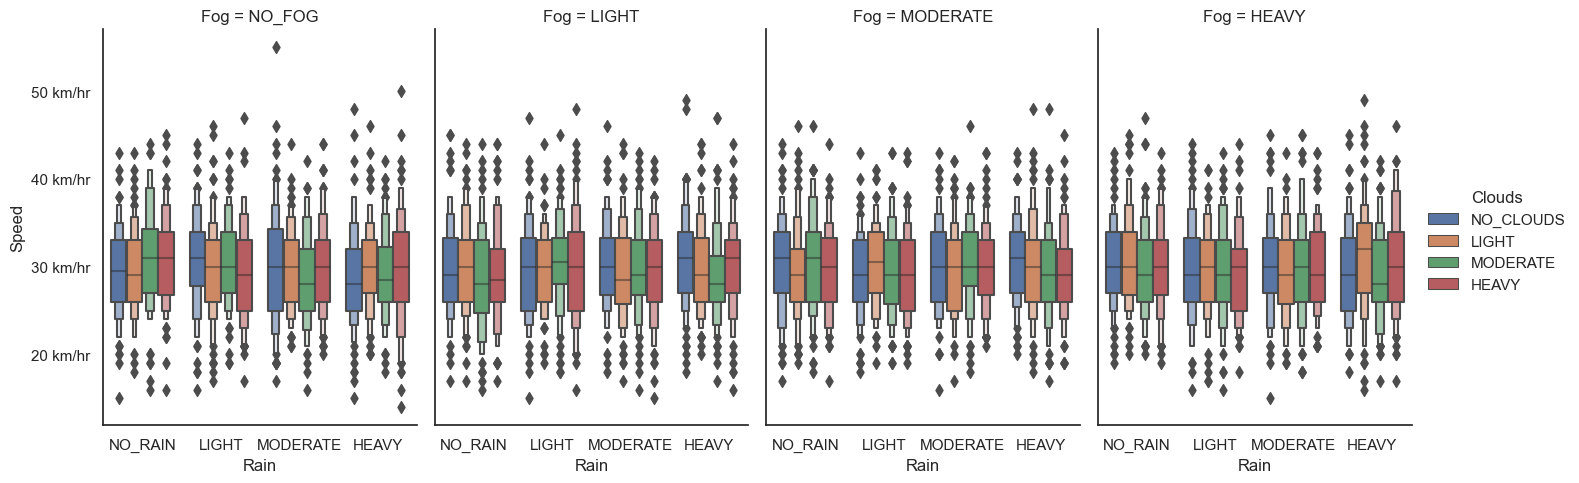

In [140]:
g = sns.catplot(
    data=df, x="Rain", y="Speed", hue="Clouds",
    kind="boxen", col="Fog", aspect=0.7 
)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter('{x:.0f} km/hr')

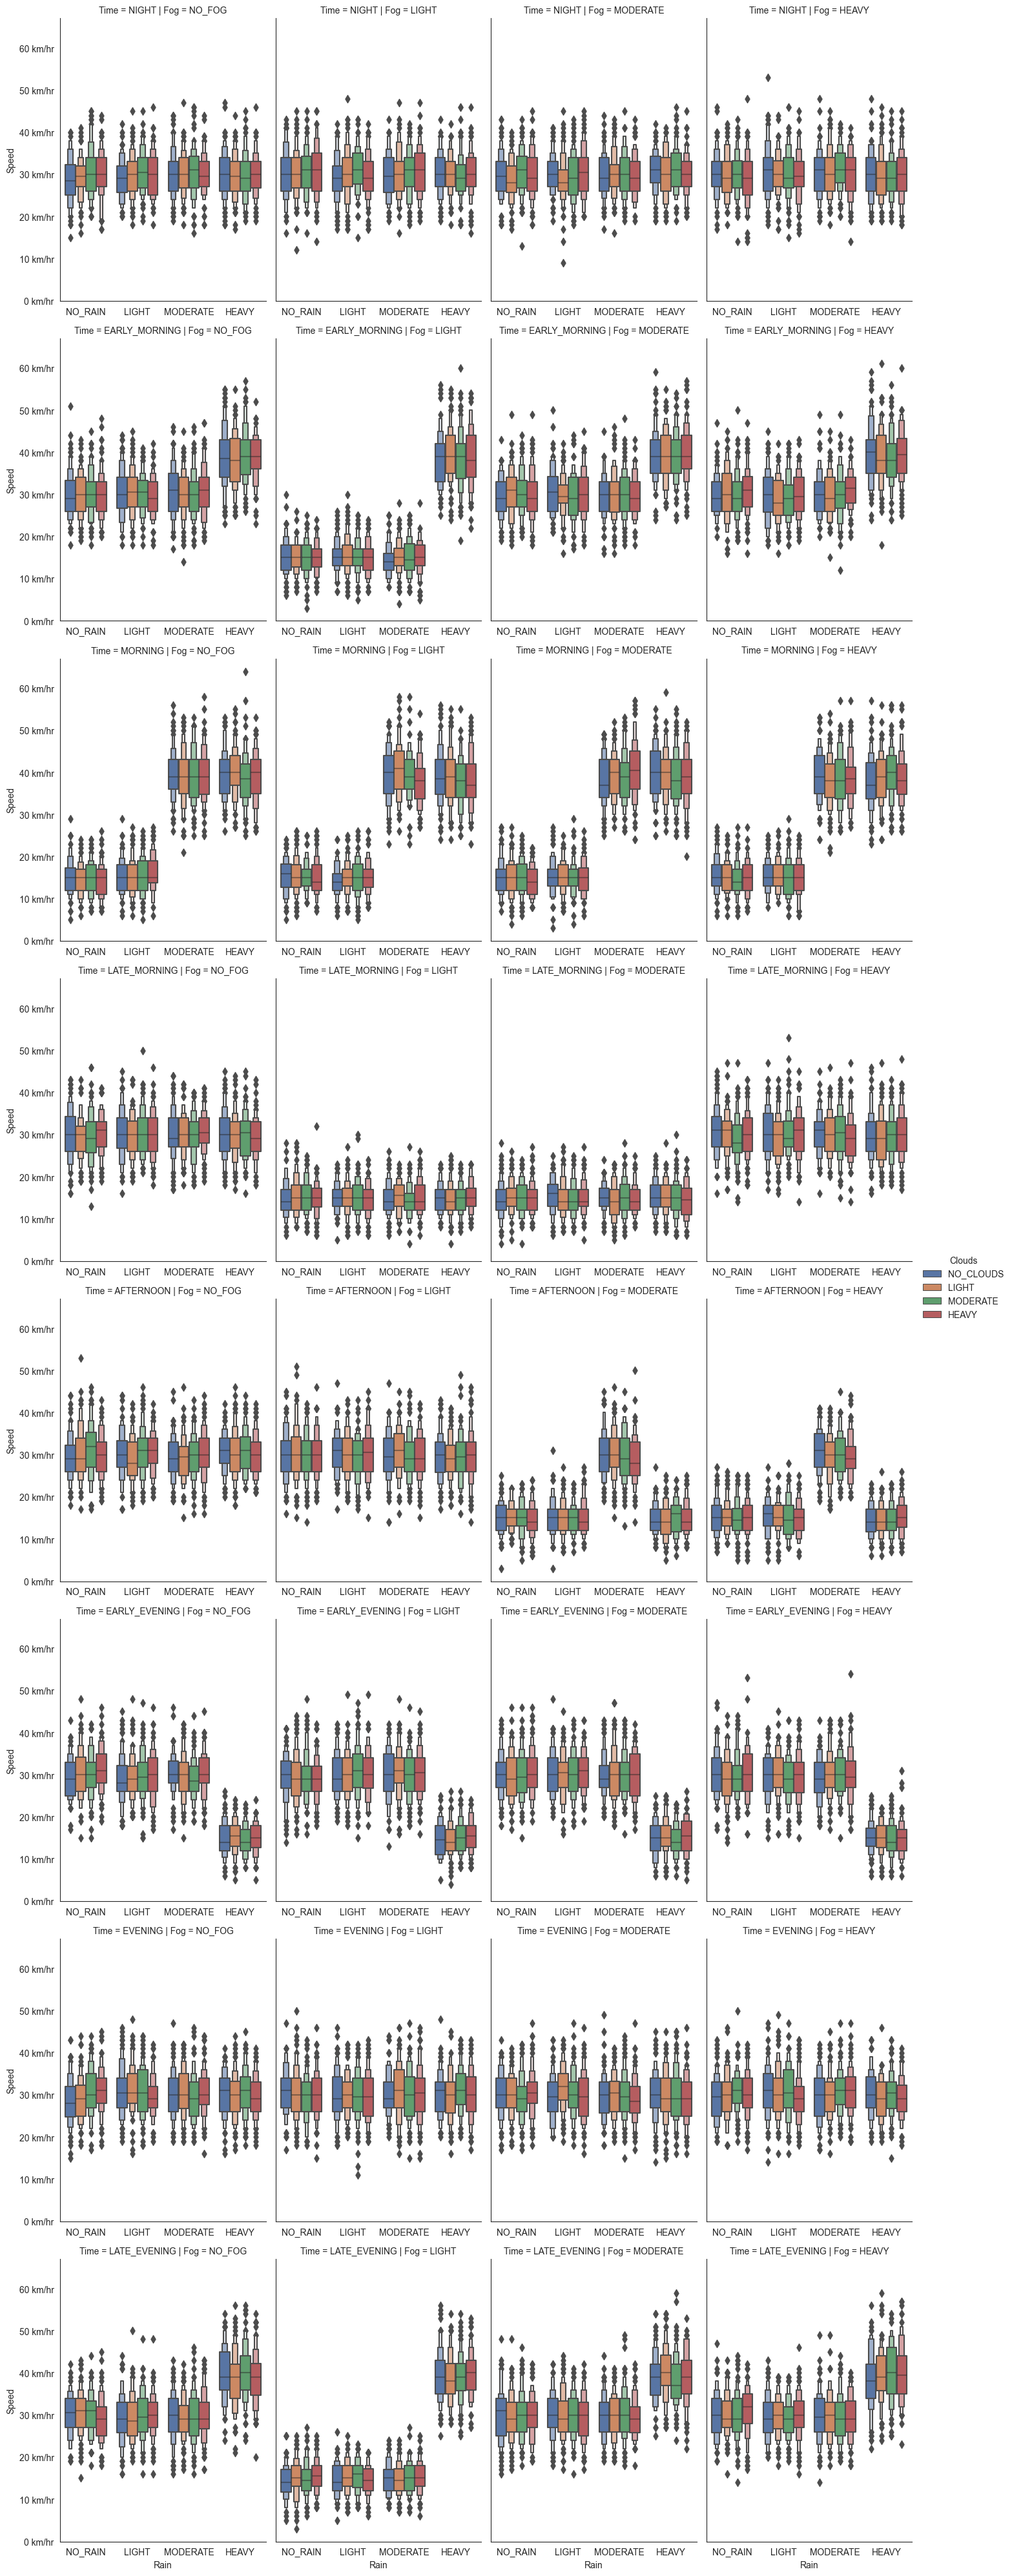

In [53]:
g = sns.catplot(
    data=df, x="Rain", y="Speed", hue="Clouds", sharex=False,
    kind="boxen", row="Time", col="Fog", aspect=0.7 
)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter('{x:.0f} km/hr')

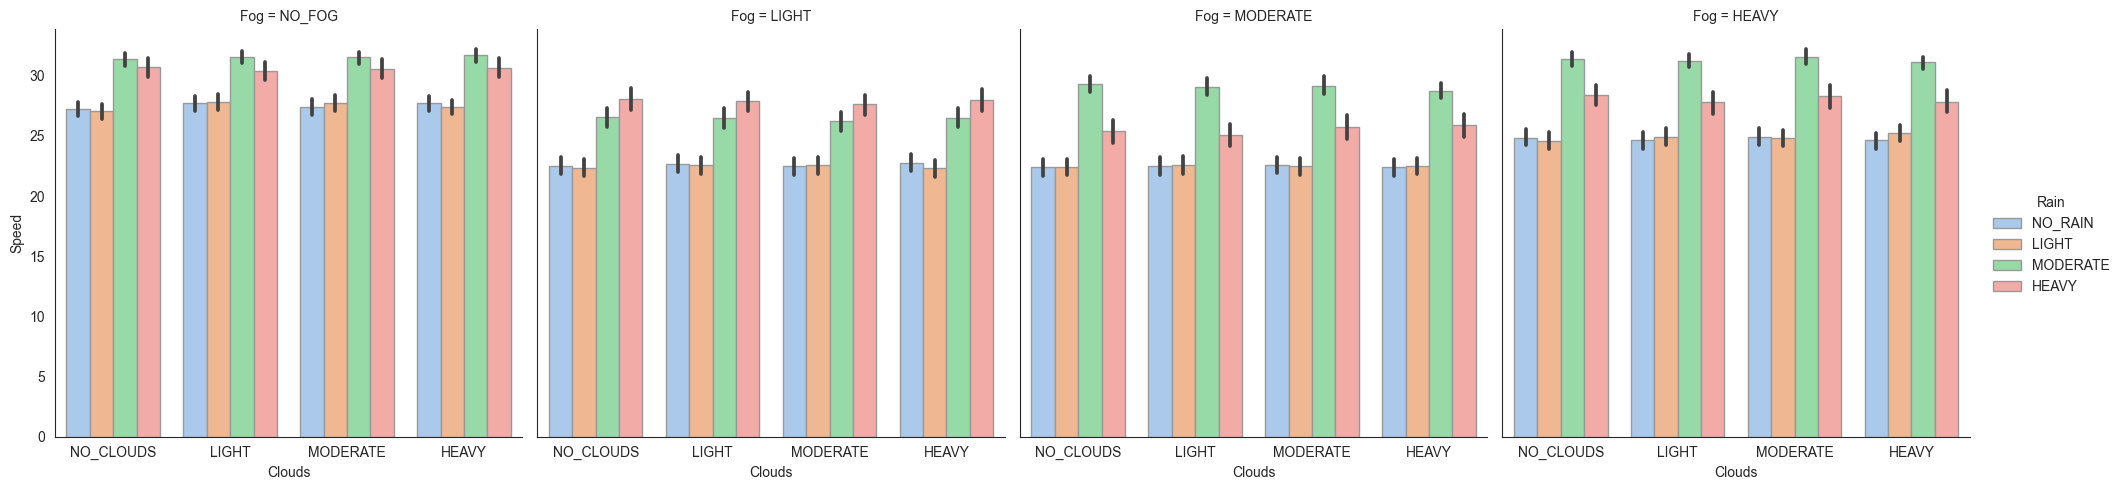

In [40]:
sns.catplot(
    data=df, x="Clouds", y="Speed", hue="Rain", col="Fog",
    kind="bar", palette="pastel", edgecolor=".6",
)